----------
**IBM Attrition Analysis and Prediction**
=====================================

***XGB : CV - Accuracy (5 folds) =  .891***

***Vincent Lugat***

*October 2018*

----------

![](http://image.noelshack.com/fichiers/2018/41/1/1539014632-1-bye.png)

source : http://thecontextofthings.com/2017/01/06/employee-attrition/

- <a href='#1'>1. Load libraries and read the data</a>  
    - <a href='#1.1'>1.1. Load libraries</a> 
    - <a href='#1.2'>1.2. Read the data</a> 
    - <a href='#1.3'>1.3. Missing values</a> 
    - <a href='#1.4'>1.4. Reassign target and drop useless features</a> 
- <a href='#2'>2. Exploratory Data Analysis (EDA)</a> 
    - <a href='#2.1'>2.1. Head and describe</a> 
    - <a href='#2.2'>2.2. Target distribution (number and %)</a> 
    - <a href='#2.3'>2.3. Features distribution and barplot (hue = Attrition)</a> 
    - <a href='#2.4'>2.4. Pie plot and barplot</a> 
- <a href='#3'>3. Feature engineering and selection</a>
    - <a href='#3.1'>3.1. New features (24) </a> 
    - <a href='#3.2'>3.2. Drop some features</a> 
    - <a href='#3.3'>3.3. Features encoding and scaling</a>
    - <a href='#3.4'>3.4. Correlation Matrix</a>
    - <a href='#3.5'>3.5. Remove collinear features</a>
- <a href='#4'>4. Define functions</a>
    - <a href='#4.1'>4.1. Define model performance plot </a> 
    - <a href='#4.2'>4.2. Define feature importance plot </a> 
    - <a href='#4.3'>4.3. Define cumulative gains curve</a>
    - <a href='#4.4'>4.4. Define cross validation metrics</a>
- <a href='#5'>5. Prepare dataset</a>
    - <a href='#5.1'>5.1. Define (X,  y)</a> 
    - <a href='#5.2'>5.2. Train test split</a> 
- <a href='#6'>6. XGBoost - RandomizedSearchCV to optimize hyperparameters (800 comb)</a> 

- <a href='#7'>7. XGBoost - With best hyperparameters = 89.11</a>
    - <a href='#7.1'>7.1. XGBoost - Modeling and performance plot</a> 
    - <a href='#7.2'>7.2. XGBoost - Feature importance </a> 
    - <a href='#7.3'>7.3. XGBoost - Cumulative gains curve</a> 
    - <a href='#7.4'>7.4. XGBoost - Cross validation (5 folds)</a> 

# <a id='1'>1. Load libraries and read the data</a> 

## <a id='1.1'>1.1. Load libraries</a> 

In [1]:
# Python libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score
#import xgboost as xgb
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore')

C:\Users\DELL\AppData\Local\Temp\ipykernel_6052\3979240252.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## <a id='1.2'>1.2. Read the data</a>

In [2]:
data = pd.read_csv('../../../data/raw/jeuDeDonnees.csv', sep=';')

In [3]:
data.head()

Age Attrition    Voyage_affaires  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0               1.0          2  Life Sciences              1               1   
1               8.0          1  Life Sciences              1               2   
2               2.0          2          Other              1               4   
3               3.0          4  Life Sciences              1               5   
4               2.0          1        Medical              1               7   

   ...  Satisfaction_relationnelle StandardHours  StockOptionLevel  \
0  ...                           1            80                 0   
1  ...                           4            80                 1   
2  ...                           2            80                 0   
3  ...                           3            80                 0   
4  ...                           4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

## <a id='1.3'>1.3. Missing values</a>

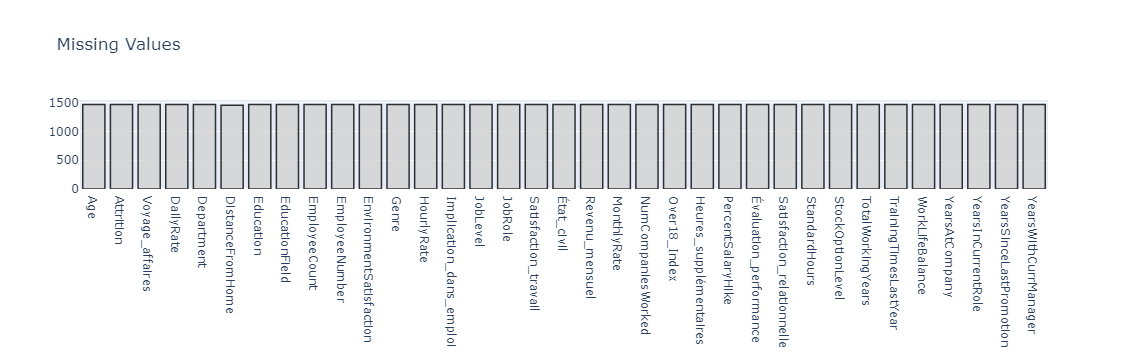

In [4]:
null_feat = pd.DataFrame(len(data['Attrition']) - data.isnull().sum(), columns = ['Count'])

trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey',
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  "Missing Values")
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

In [5]:
data.dropna(axis=0, inplace=True)

## <a id='1.4'>1.4. Reassign target and drop useless features</a>

In [6]:
# Reassign target
data.Attrition.replace(to_replace = dict(Yes = 1, No = 0), inplace = True)
# Drop useless feat
data = data.drop(columns=['StandardHours', 
                          'EmployeeCount', 
                          #'Over18',
                        ])

# <a id='2'>2. Exploratory Data Analysis (EDA)</a>

## <a id='2.1'>2.1. Head and describe</a> 

In [7]:
# head
data.head()

Age  Attrition    Voyage_affaires  DailyRate              Department  \
0   41          1      Travel_Rarely       1102                   Sales   
1   49          0  Travel_Frequently        279  Research & Development   
2   37          1      Travel_Rarely       1373  Research & Development   
3   33          0  Travel_Frequently       1392  Research & Development   
4   27          0      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeNumber  \
0               1.0          2  Life Sciences               1   
1               8.0          1  Life Sciences               2   
2               2.0          2          Other               4   
3               3.0          4  Life Sciences               5   
4               2.0          1        Medical               7   

   EnvironmentSatisfaction  ... Évaluation_performance  \
0                        2  ...                      3   
1                        3  ...                      4   
2                        4  ...                      3   
3                        4  ...                      3   
4                        1  ...                      3   

   Satisfaction_relationnelle  StockOptionLevel  TotalWorkingYears  \
0                           1                 0                  8   
1                           4                 1                 10   
2                           2                 0                  7   
3                           3                 0                  8   
4                           4                 1                  6   

  TrainingTimesLastYear  WorkLifeBalance YearsAtCompany  YearsInCurrentRole  \
0                     0                1              6                   4   
1                     3                3             10                   7   
2                     3                3              0                   0   
3                     3                3              8                   7   
4                     3                3              2                   2   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                        0                     5  
1                        1                     7  
2                        0                     0  
3                        3                     0  
4                        2                     2  

[5 rows x 33 columns]

In [8]:
# describe
data.describe()

Age    Attrition    DailyRate  DistanceFromHome    Education  \
count  1454.000000  1454.000000  1454.000000       1454.000000  1454.000000   
mean     36.922971     0.161623   803.034388          9.146492     2.913343   
std       9.124337     0.368231   403.417181          8.083264     1.023832   
min      18.000000     0.000000   102.000000          1.000000     1.000000   
25%      30.000000     0.000000   465.250000          2.000000     2.000000   
50%      36.000000     0.000000   802.000000          7.000000     3.000000   
75%      43.000000     0.000000  1157.000000         14.000000     4.000000   
max      60.000000     1.000000  1499.000000         29.000000     5.000000   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  \
count     1454.000000              1454.000000  1454.000000   
mean      1028.010316                 2.715956    65.838377   
std        601.959661                 1.093587    20.328598   
min          1.000000                 1.000000    30.000000   
25%        493.250000                 2.000000    48.000000   
50%       1026.500000                 3.000000    66.000000   
75%       1557.750000                 4.000000    83.000000   
max       2068.000000                 4.000000   100.000000   

       Implication_dans_emploi     JobLevel  ...  Évaluation_performance  \
count              1454.000000  1454.000000  ...             1454.000000   
mean                  2.730399     2.065337  ...                3.155433   
std                   0.712834     1.110171  ...                0.362442   
min                   1.000000     1.000000  ...                3.000000   
25%                   2.000000     1.000000  ...                3.000000   
50%                   3.000000     2.000000  ...                3.000000   
75%                   3.000000     3.000000  ...                3.000000   
max                   4.000000     5.000000  ...                4.000000   

       Satisfaction_relationnelle  StockOptionLevel  TotalWorkingYears  \
count                 1454.000000       1454.000000        1454.000000   
mean                     2.709766          0.792297          11.286107   
std                      1.082782          0.850599           7.770405   
min                      1.000000          0.000000           0.000000   
25%                      2.000000          0.000000           6.000000   
50%                      3.000000          1.000000          10.000000   
75%                      4.000000          1.000000          15.000000   
max                      4.000000          3.000000          40.000000   

       TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
count            1454.000000      1454.000000     1454.000000   
mean                2.801926         2.761348        7.001376   
std                 1.283318         0.706955        6.088587   
min                 0.000000         1.000000        0.000000   
25%                 2.000000         2.000000        3.000000   
50%                 3.000000         3.000000        5.000000   
75%                 3.000000         3.000000        9.750000   
max                 6.000000         4.000000       37.000000   

       YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
count         1454.000000              1454.000000           1454.000000  
mean             4.229023                 2.181568              4.132737  
std              3.625893                 3.208521              3.575687  
min              0.000000                 0.000000              0.000000  
25%              2.000000                 0.000000              2.000000  
50%              3.000000                 1.000000              3.000000  
75%              7.000000                 3.000000              7.000000  
max             18.000000                15.000000             17.000000  

[8 rows x 25 columns]

## <a id='2.2'>2.2. Target distribution (number and %)</a> 

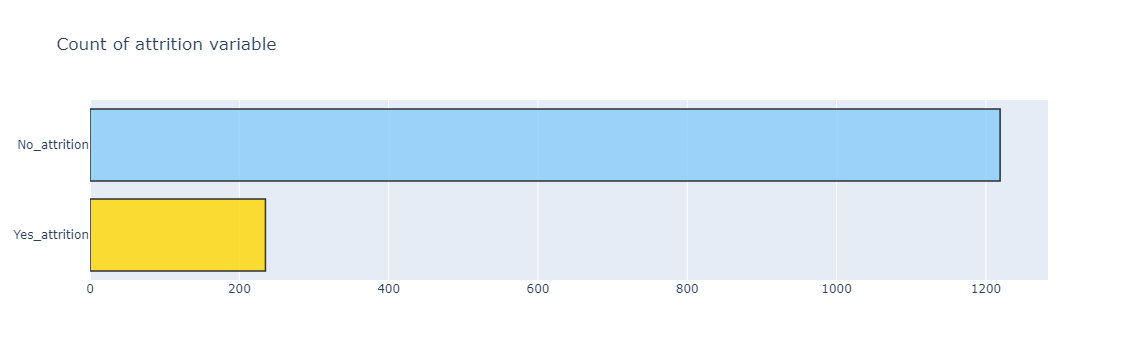

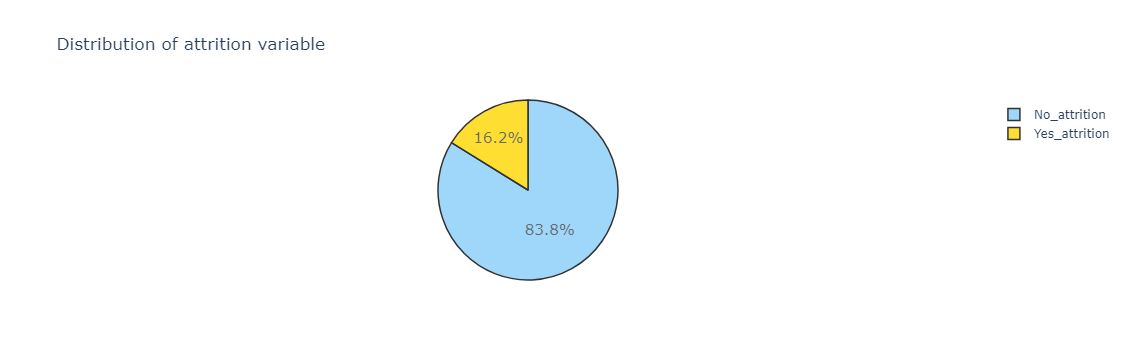

In [9]:
attrition = data[(data['Attrition'] != 0)]
no_attrition = data[(data['Attrition'] == 0)]

#------------COUNT-----------------------
trace = go.Bar(x = (len(attrition), len(no_attrition)), y = ['Yes_attrition', 'No_attrition'], orientation = 'h', opacity = 0.8, marker=dict(
        color=['gold', 'lightskyblue'],
        line=dict(color='#000000',width=1.5)))

layout = dict(title =  'Count of attrition variable')
                    
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

#------------PERCENTAGE-------------------
trace = go.Pie(labels = ['No_attrition', 'Yes_attrition'], values = data['Attrition'].value_counts(), 
               textfont=dict(size=15), opacity = 0.8,
               marker=dict(colors=['lightskyblue','gold'], 
                           line=dict(color='#000000', width=1.5)))


layout = dict(title =  'Distribution of attrition variable')
           
fig = dict(data = [trace], layout=layout)
py.iplot(fig)

## <a id='2.3'>2.3. Features distribution and barplot (hue = Attrition)</a> 

In [10]:
def plot_distribution(var_select, bin_size) : 
# Calculate the correlation coefficient between the new variable and the target
    corr = data['Attrition'].corr(data[var_select])
    corr = np.round(corr,3)
    tmp1 = attrition[var_select]
    tmp2 = no_attrition[var_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Yes_attrition', 'No_attrition']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, curve_type='kde', bin_size = bin_size)
    
    fig['layout'].update(title = var_select+' '+'(corr target ='+ str(corr)+')')

    py.iplot(fig, filename = 'Density plot')

In [11]:
def barplot(var_select, x_no_numeric) :
    tmp1 = data[(data['Attrition'] != 0)]
    tmp2 = data[(data['Attrition'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Attrition']), )
    tmp3['Attr%'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100
    if x_no_numeric == True  : 
        tmp3 = tmp3.sort_values(1, ascending = False)

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        name='Yes_Attrition',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        name='No_Attrition', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['Attr%'],
        yaxis = 'y2',
        name='% Attrition', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% Attrition'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

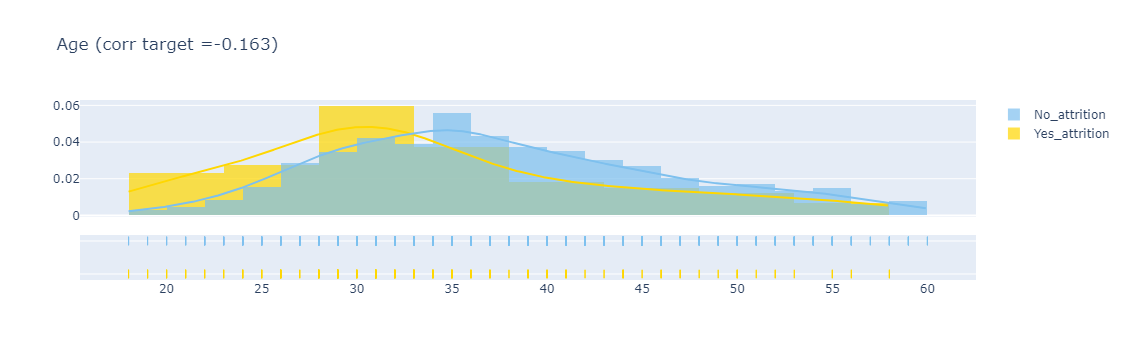

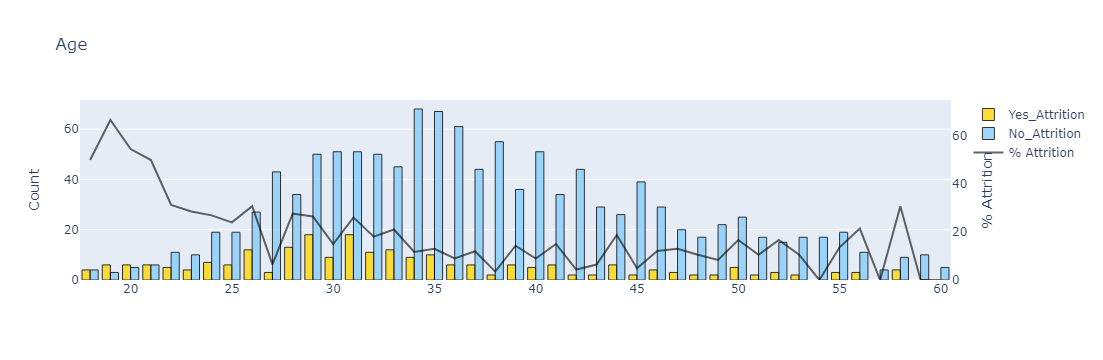

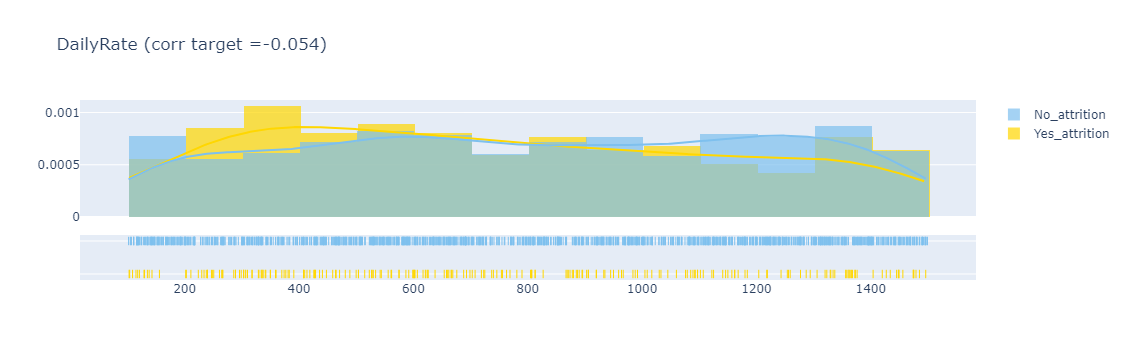

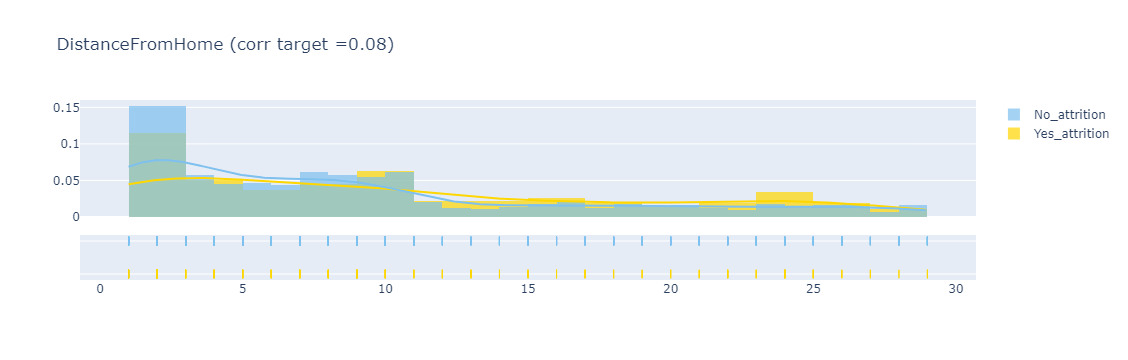

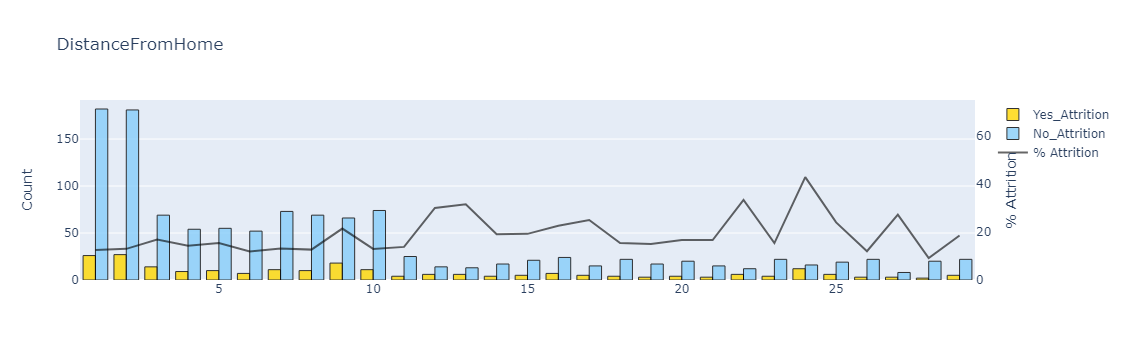

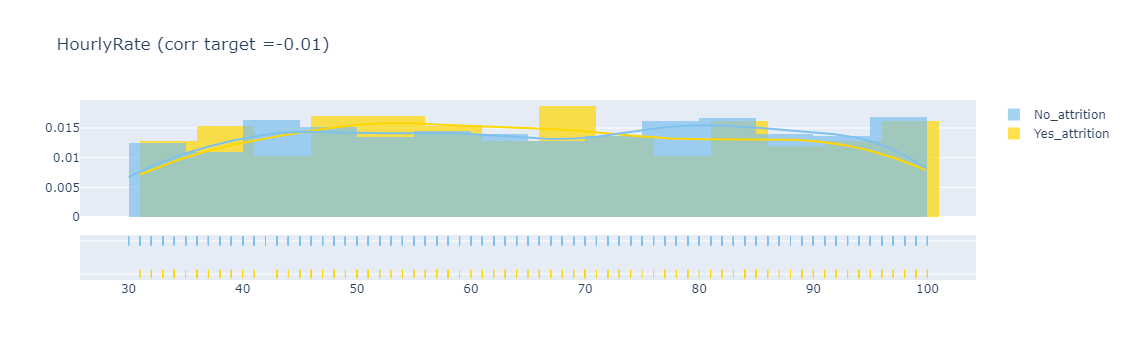

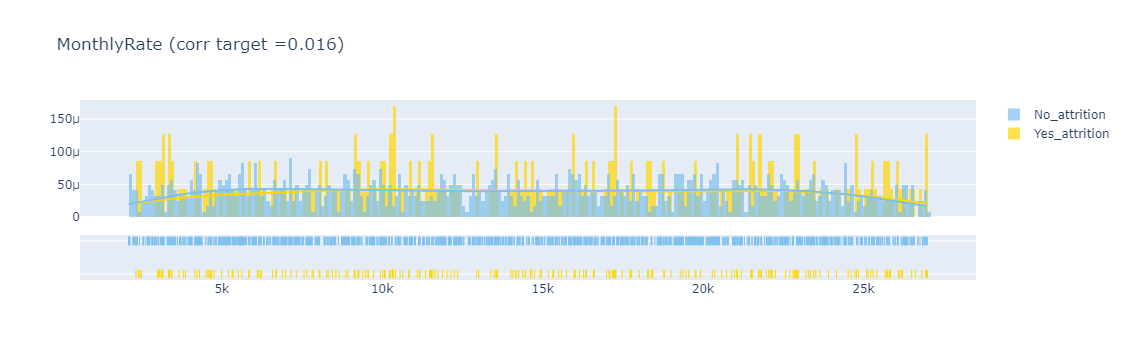

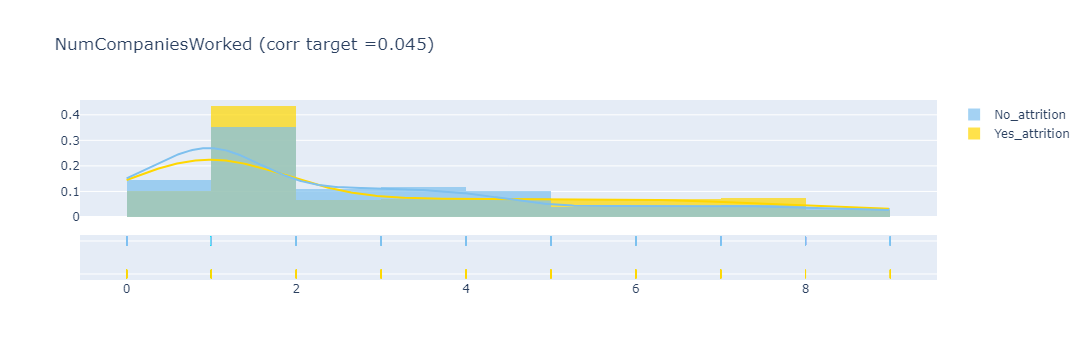

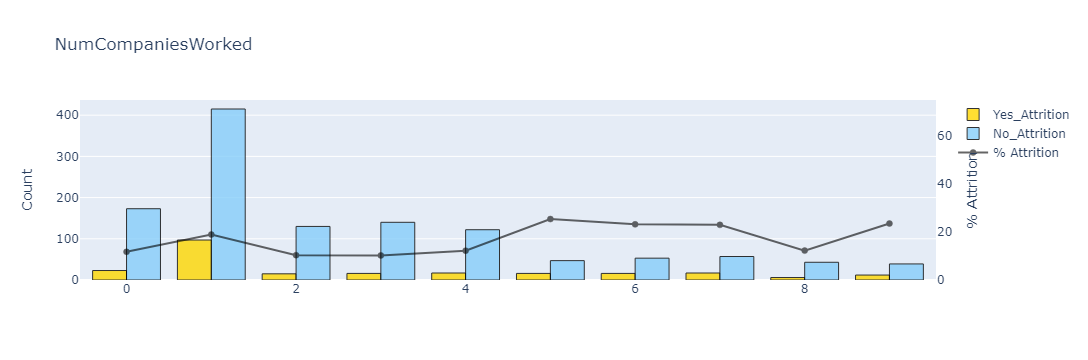

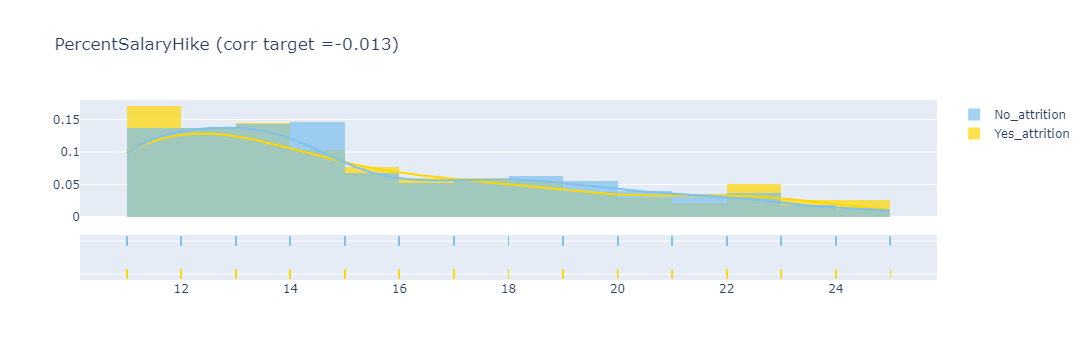

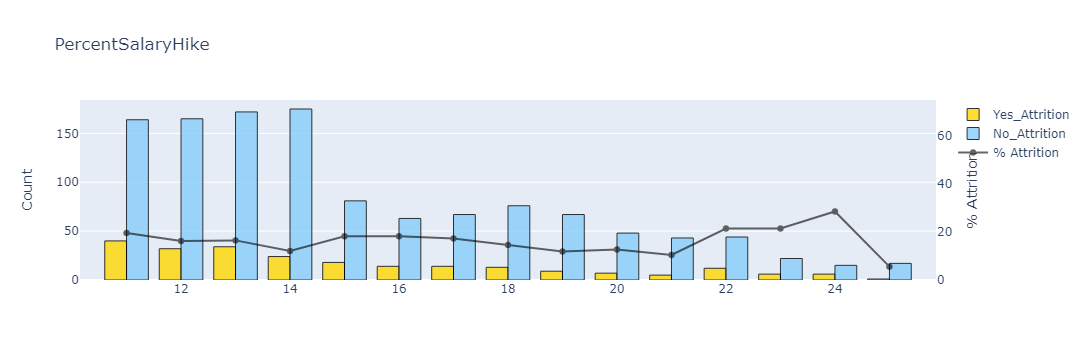

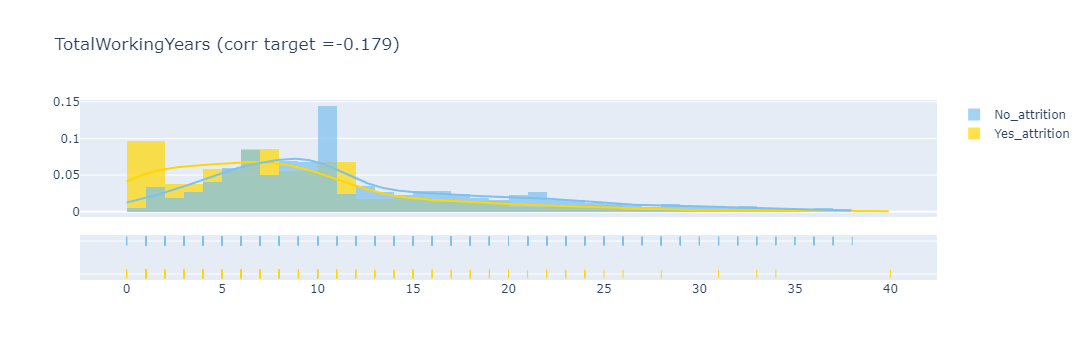

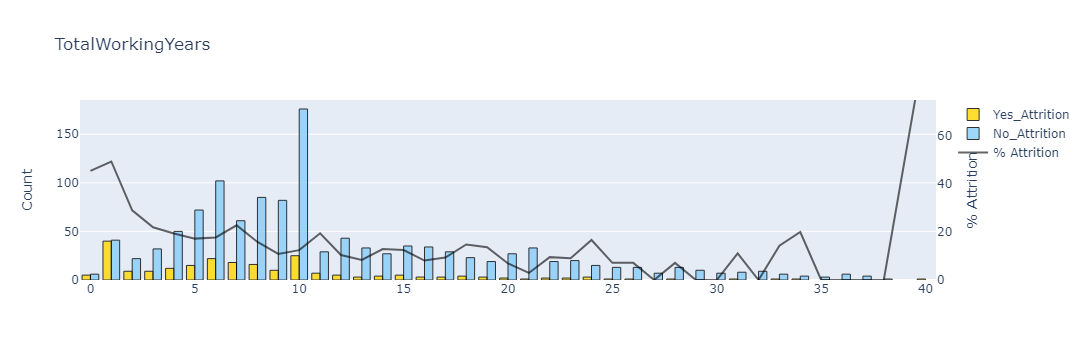

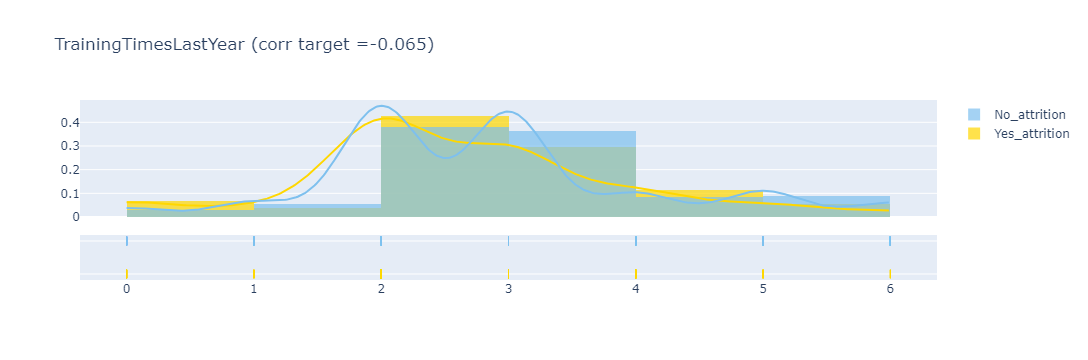

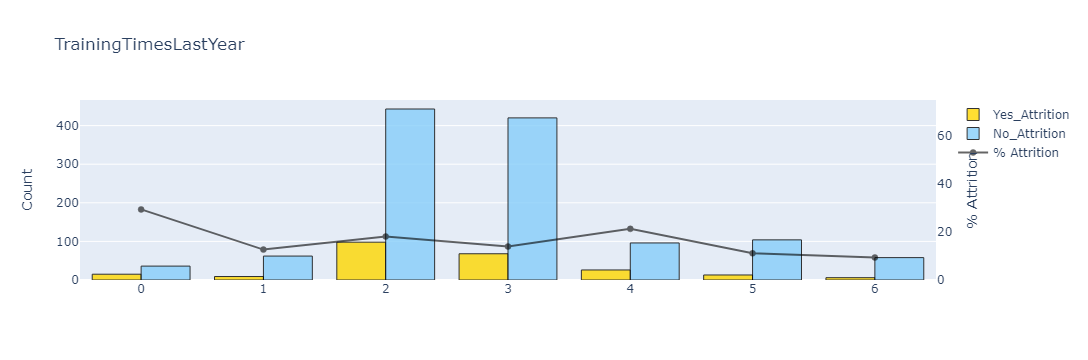

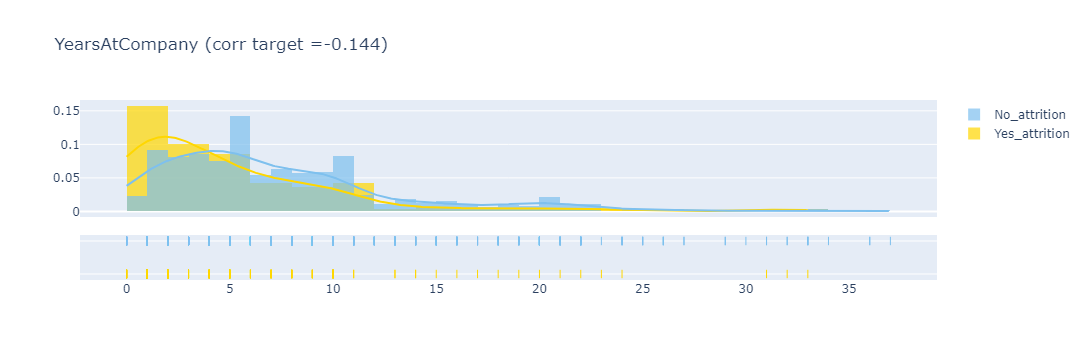

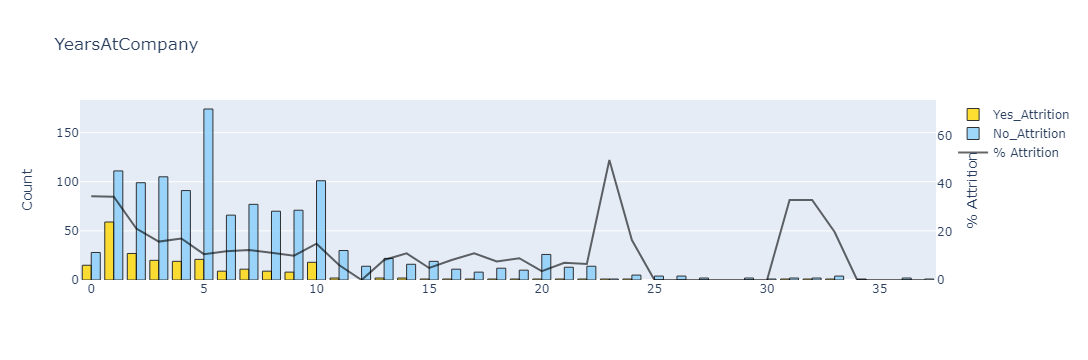

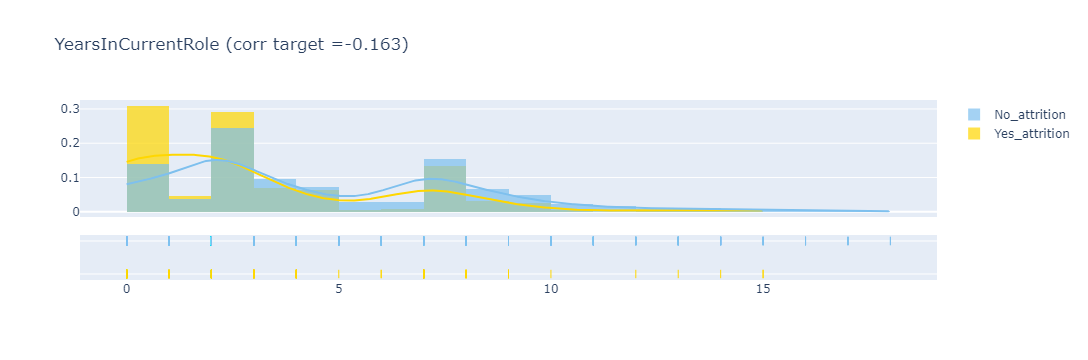

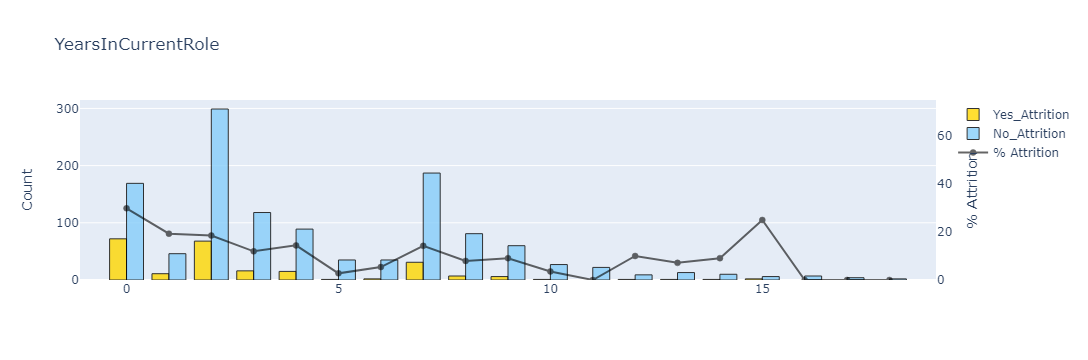

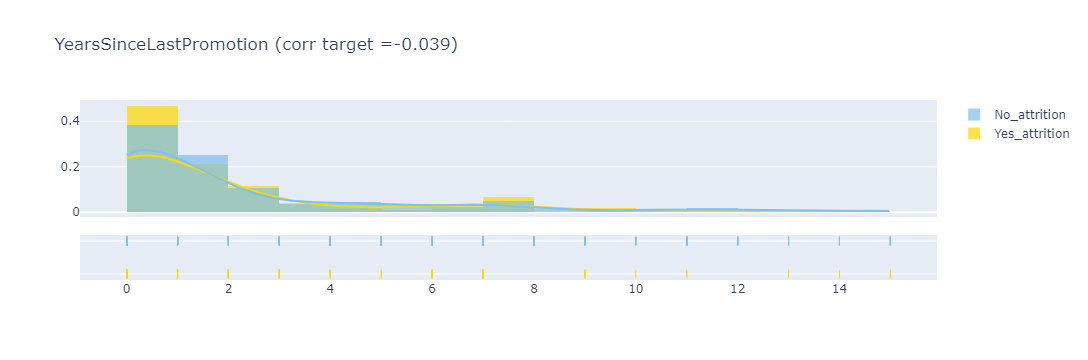

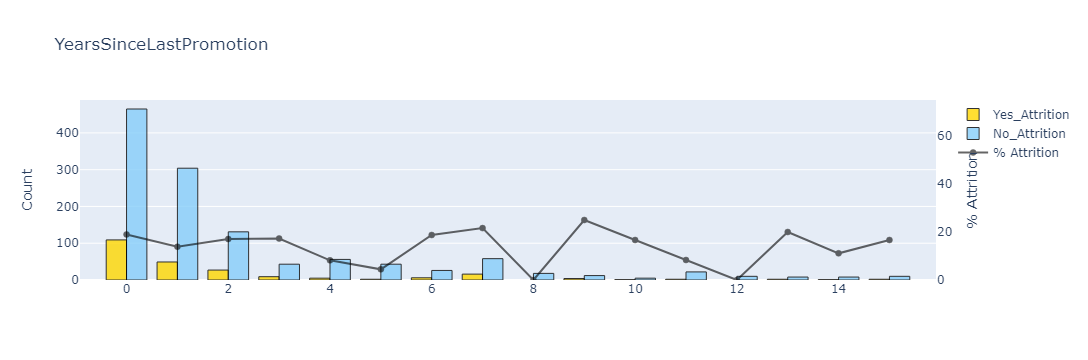

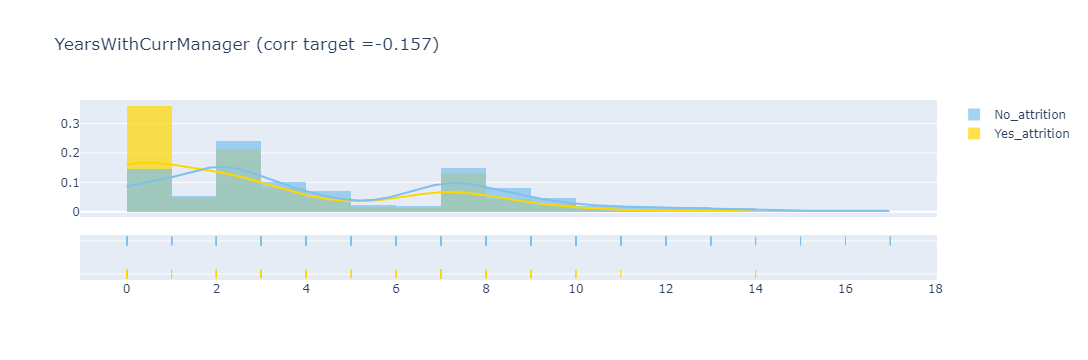

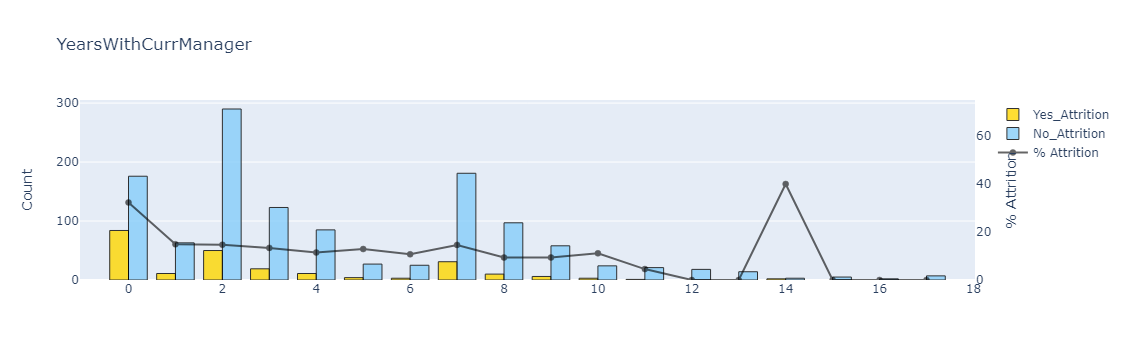

In [12]:
plot_distribution('Age', False)
barplot('Age', False)
plot_distribution('DailyRate', 100)
plot_distribution('DistanceFromHome', False)
barplot('DistanceFromHome', False)
plot_distribution('HourlyRate', False)
#plot_distribution('MonthlyIncome', 100)
plot_distribution('MonthlyRate', 100)
plot_distribution('NumCompaniesWorked', False)
barplot('NumCompaniesWorked',False)
plot_distribution('PercentSalaryHike', False)
barplot('PercentSalaryHike', False) 
plot_distribution('TotalWorkingYears', False)
barplot('TotalWorkingYears', False)
plot_distribution('TrainingTimesLastYear', False)
barplot('TrainingTimesLastYear',False)
plot_distribution('YearsAtCompany', False)
barplot('YearsAtCompany', False)
plot_distribution('YearsInCurrentRole', False)
barplot('YearsInCurrentRole', False)
plot_distribution('YearsSinceLastPromotion', False)
barplot('YearsSinceLastPromotion', False)
plot_distribution('YearsWithCurrManager', False)
barplot('YearsWithCurrManager', False)

## <a id='2.4'>2.4. Pie plot and barplot</a> 

In [13]:
def plot_pie(var_select) :
    
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightgrey', 'orange', 'white', 'lightpink']
    trace1 = go.Pie(values  = attrition[var_select].value_counts().values.tolist(),
                    labels  = attrition[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "attrition employes",
                    marker  = dict(colors = colors, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = no_attrition[var_select].value_counts().values.tolist(),
                    labels  = no_attrition[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hoverinfo = "label+percent+name",
                    marker  = dict(colors = colors, line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Non attrition employes" )

    layout = go.Layout(dict(title = var_select + " distribution in employes attrition ",
                            annotations = [dict(text = "Yes_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "No_attrition",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

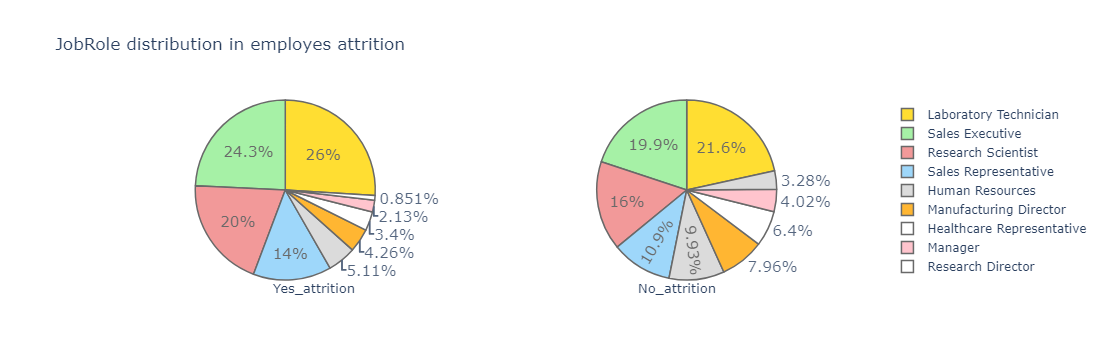

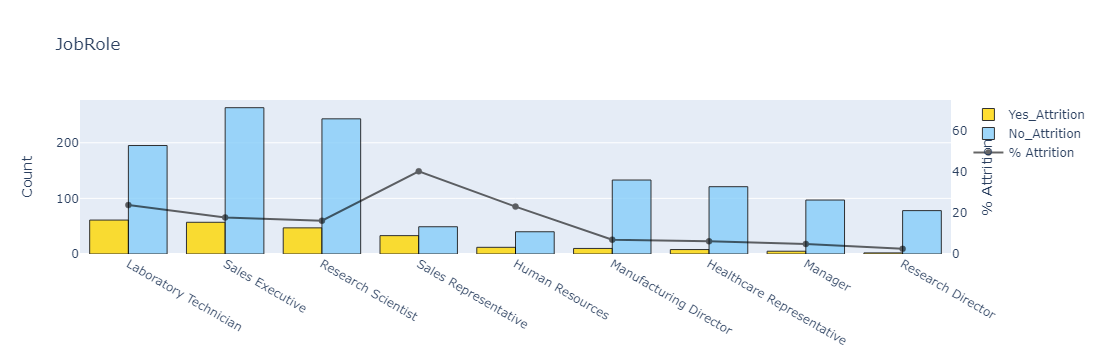

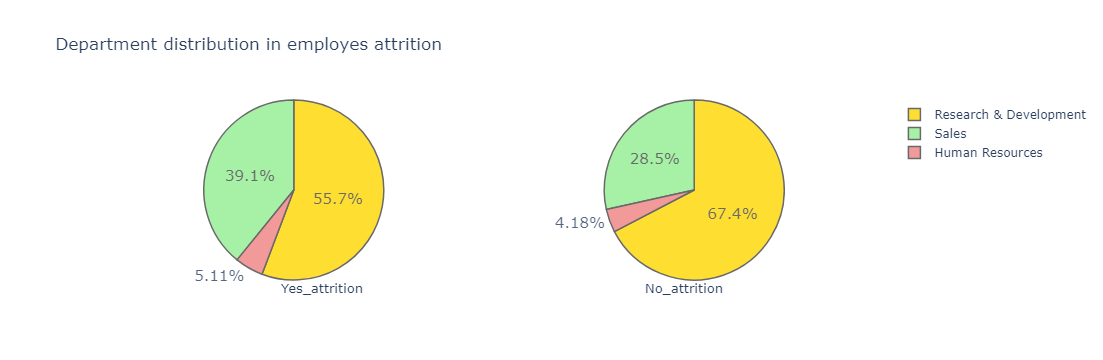

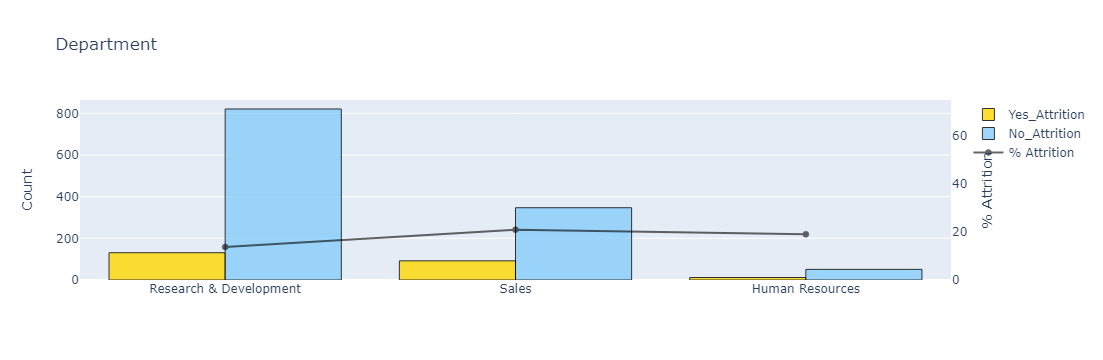

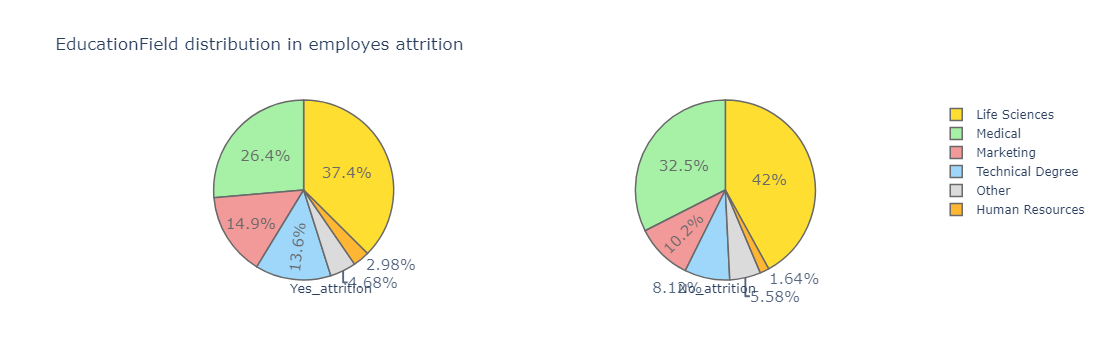

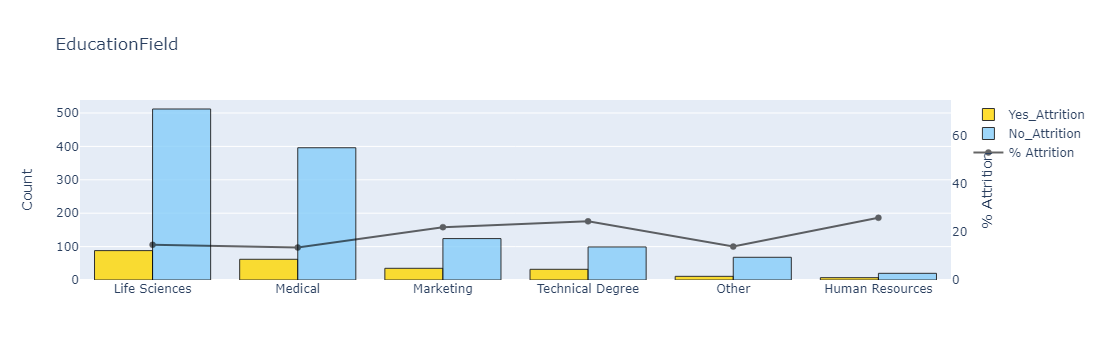

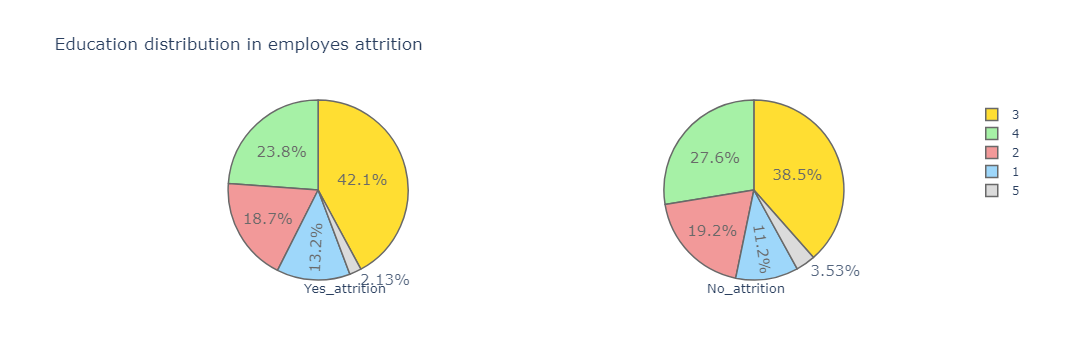

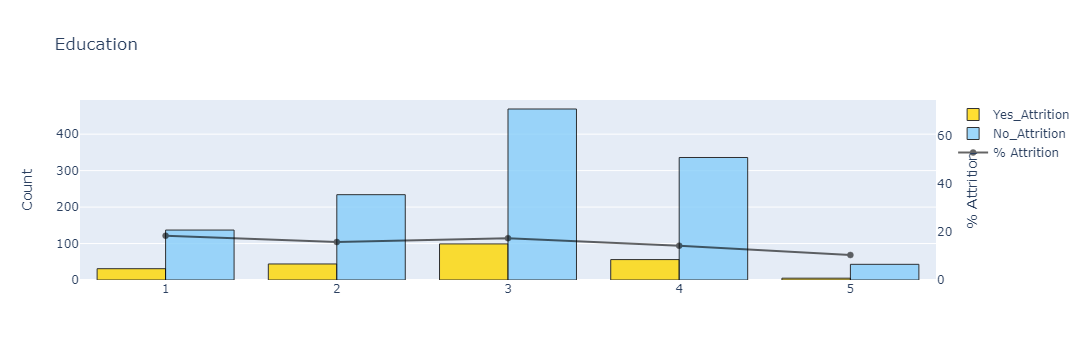

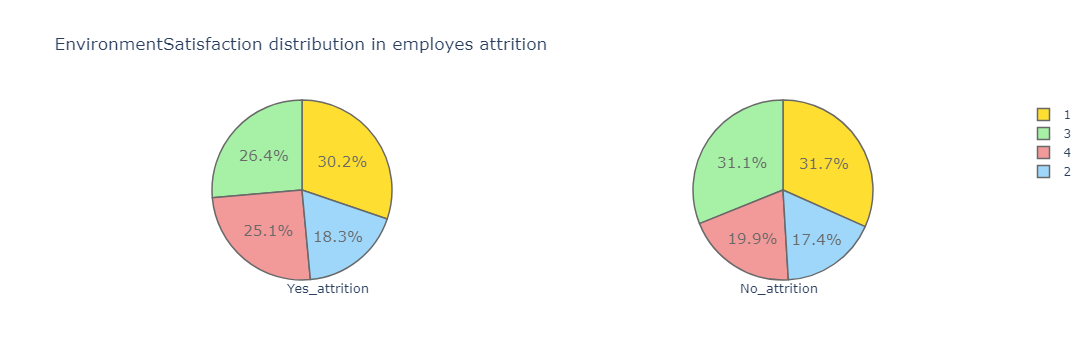

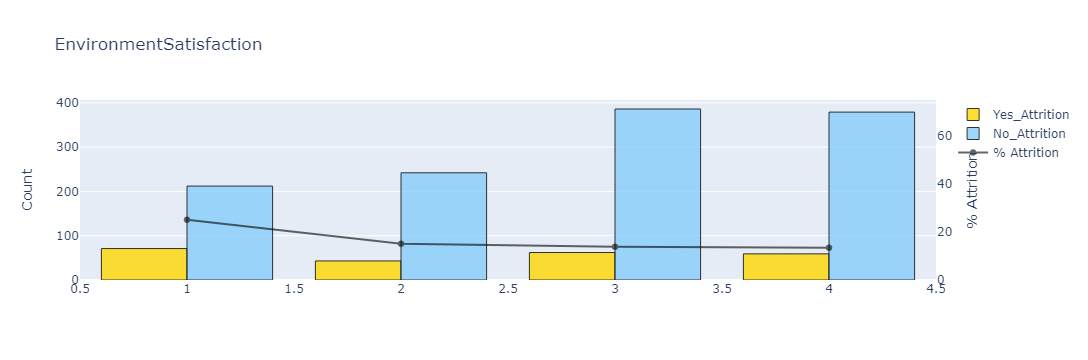

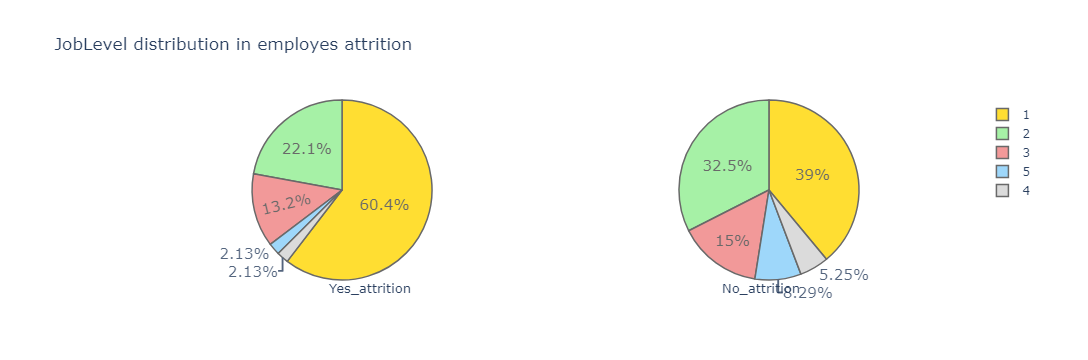

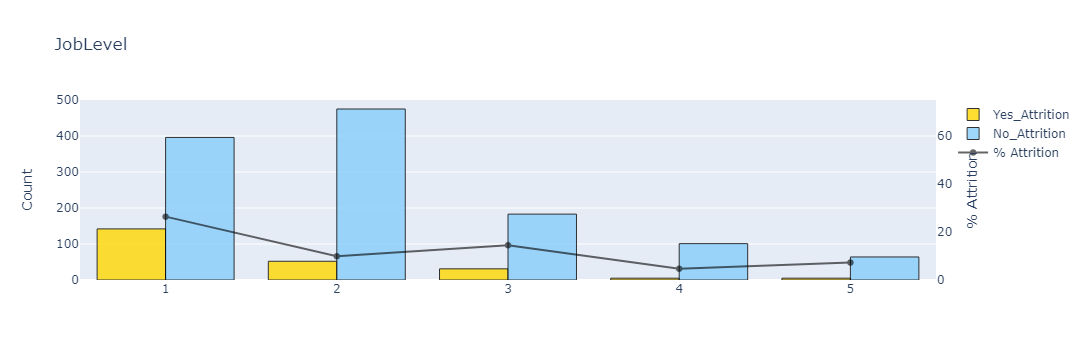

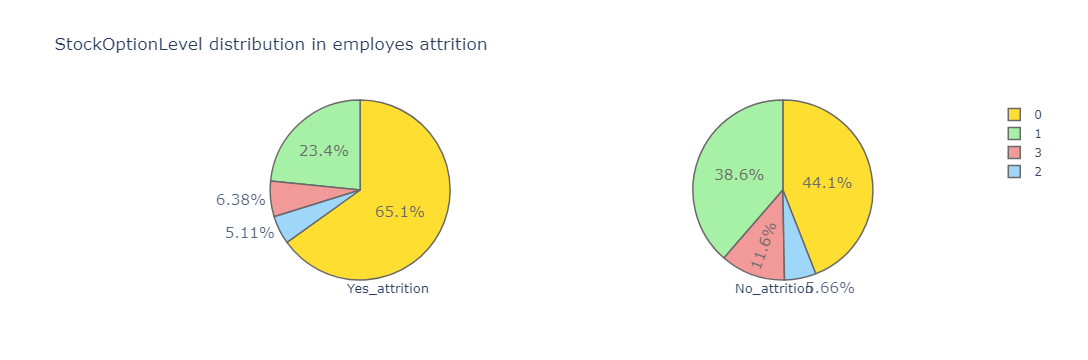

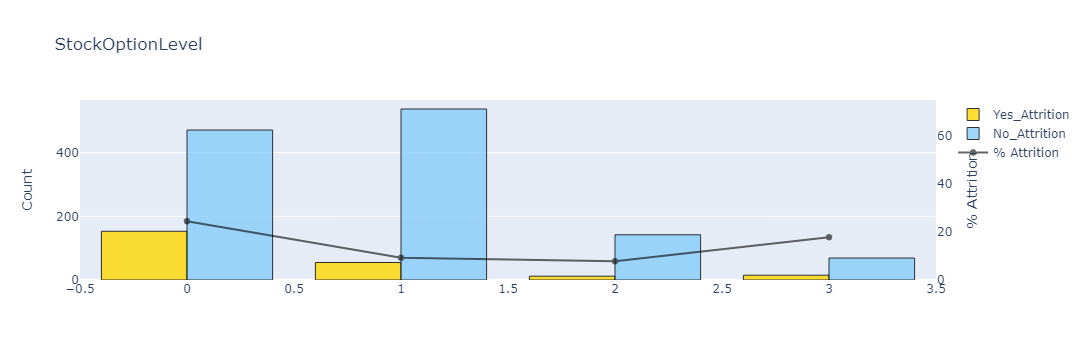

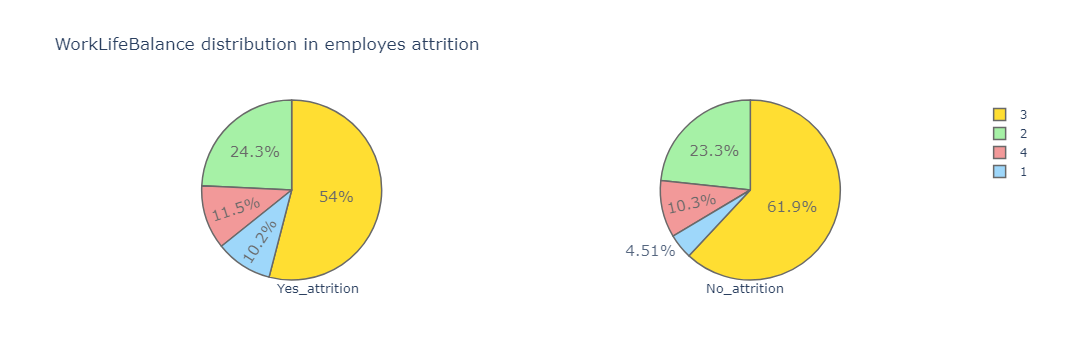

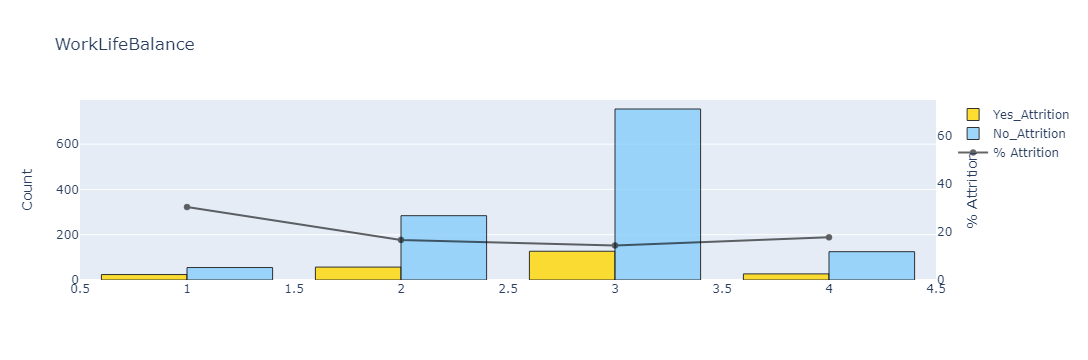

In [14]:
#plot_pie("Gender")
#barplot('Gender',True)
#plot_pie('OverTime')
#barplot('OverTime',True)
#plot_pie('BusinessTravel')
#barplot('BusinessTravel',True)
plot_pie('JobRole')
barplot('JobRole',True)
plot_pie('Department') 
barplot('Department',True)
#plot_pie('MaritalStatus')
#barplot('MaritalStatus',True)
plot_pie('EducationField') 
barplot('EducationField',True)
plot_pie('Education') 
barplot('Education',False)
plot_pie('EnvironmentSatisfaction')
barplot('EnvironmentSatisfaction',False)
#plot_pie('JobInvolvement')
#barplot('JobInvolvement', False)
plot_pie('JobLevel')
barplot('JobLevel',False)
#plot_pie('JobSatisfaction')
#barplot('JobSatisfaction',False)
#plot_pie('PerformanceRating')
#barplot('PerformanceRating',False)
#plot_pie('RelationshipSatisfaction')
#barplot('RelationshipSatisfaction', False)
plot_pie('StockOptionLevel')
barplot('StockOptionLevel', False)
plot_pie('WorkLifeBalance')
barplot('WorkLifeBalance', False)

# <a id='3'>3. Feature engineering and selection</a>

## <a id='3.1'>3.1. New features : 24</a> 

In [15]:
def SalesDpt(data) :
    if data['Department'] == 'Sales':
        return 1
    else:
        return 0
data['SalesDpt'] = data.apply(lambda data:SalesDpt(data) ,axis = 1)

def JobInvCut(data) :
    if data['JobInvolvement'] < 2.5 :
        return 1
    else:
        return 0
#data['JobInvCut'] = data.apply(lambda data:JobInvCut(data) ,axis = 1)

def MiddleTraining(data) :
    if data['TrainingTimesLastYear'] >= 3 and data['TrainingTimesLastYear'] <= 6:
        return 1
    else:
        return 0
data['MiddleTraining'] = data.apply(lambda data:MiddleTraining(data) ,axis = 1)

def MoovingPeople(data) :
    if data['NumCompaniesWorked'] > 4:
        return 1
    else:
        return 0
data['MoovingPeople'] = data.apply(lambda data:MoovingPeople(data), axis = 1)

#data['TotalSatisfaction_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction'] + data['JobSatisfaction'] + data['JobInvolvement'] + data['WorkLifeBalance'])/5

def NotSatif(data) : 
    if  data['TotalSatisfaction_mean'] < 2.35 :
        return 1
    else : 
        return 0
#data['NotSatif'] = data.apply(lambda data:NotSatif(data) ,axis = 1)

def LongDisWL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['WorkLifeBalance'] == 1 :
        return 1
    else : 
        return 0
data['LongDisWL1'] = data.apply(lambda data:LongDisWL1(data) ,axis = 1)

def LongDis(data) : 
    if  data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
data['LongDis'] = data.apply(lambda data:LongDis(data) ,axis = 1)

def LongDisJobS1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobSatisfaction'] == 1 :
        return 1
    else : 
        return 0
#data['LongDisJobS1'] = data.apply(lambda data:LongDisJobS1(data) ,axis = 1)

def LongDisJL1(data) : 
    if  data['DistanceFromHome'] > 11 and data['JobLevel'] == 1 :
        return 1
    else : 
        return 0
data['LongDisJL1'] = data.apply(lambda data:LongDisJL1(data) ,axis = 1)

def ShortDisNotSingle(data) : 
    if  data['MaritalStatus'] != 'Single' and data['DistanceFromHome'] < 5:
        return 1
    else : 
        return 0
#data['ShortDisNotSingle'] = data.apply(lambda data:ShortDisNotSingle(data) ,axis = 1)

def LongDisSingle(data) : 
    if  data['MaritalStatus'] == 'Single' and data['DistanceFromHome'] > 11:
        return 1
    else : 
        return 0
#data['LongDisSingle'] = data.apply(lambda data:LongDisSingle(data) ,axis = 1)

def Engaged(data) : 
    if data['Age'] > 35 and data['MaritalStatus'] != 'Single':
        return 1
    else : 
        return 0
#data['Engaged'] = data.apply(lambda data:Engaged(data) ,axis = 1)

def YoungAndBadPaid(data) : 
    if data['Age'] < 35 and data['Age'] > 23 and (data['MonthlyIncome'] < 3500):
        return 1
    else : 
        return 0
#data['YoungAndBadPaid'] = data.apply(lambda data:YoungAndBadPaid(data) ,axis = 1)

def YoungNeverEngaged(data) : 
    if data['Age'] < 24 and data['MaritalStatus'] == 'Single' :
        return 1
    else : 
        return 0
#data['YoungNeverEngaged'] = data.apply(lambda data:YoungNeverEngaged(data) ,axis = 1)

data['Time_in_each_comp'] = (data['Age'] - 20) / ((data)['NumCompaniesWorked'] + 1)
#data['RelSatisf_mean'] = (data['RelationshipSatisfaction']  + data['EnvironmentSatisfaction']) / 2
#data['JobSatisf_mean'] = (data['JobSatisfaction'] + data['JobInvolvement']) / 2
#data['Income_Distance'] = data['MonthlyIncome'] / data['DistanceFromHome']
data['Hrate_Mrate'] = data['HourlyRate'] / data['MonthlyRate']
data['Stability'] = data['YearsInCurrentRole'] / data['YearsAtCompany']
data['Stability'].fillna((data['Stability'].mean()), inplace=True)
#data['Income_YearsComp'] = data['MonthlyIncome'] / data['YearsAtCompany']
#data['Income_YearsComp'] = data['Income_YearsComp'].replace(np.Inf, 0)
data['Fidelity'] = (data['NumCompaniesWorked']) / data['TotalWorkingYears']
data['Fidelity'] = data['Fidelity'].replace(np.Inf, 0)

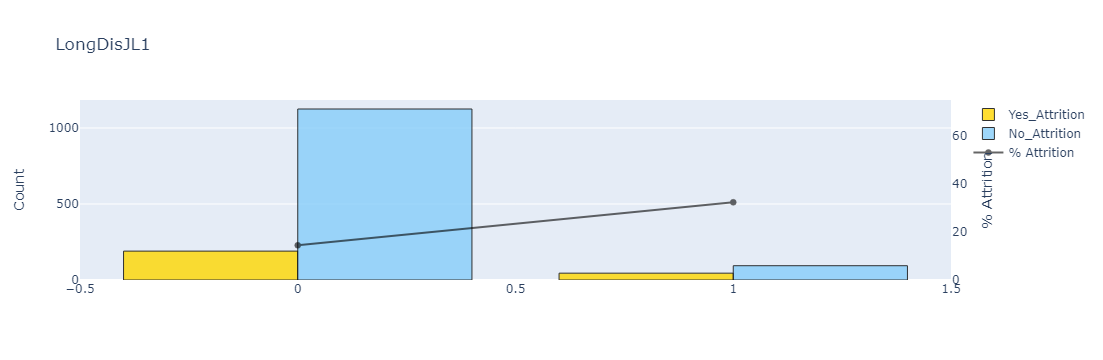

In [16]:
#barplot('Engaged', False)
#barplot('YoungAndBadPaid', False)
#barplot('YoungNeverEngaged', False)
#barplot('LongDisSingle', False)
barplot('LongDisJL1', False)
#barplot('ShortDisNotSingle', False)

## <a id='3.2'>3.2. Drop some features</a> 

In [17]:
data = data.drop(columns=[
                        'Age',
                        #'MonthlyIncome',
                        'YearsAtCompany',
                        'DistanceFromHome',
                        #'PerformanceRating',
                        'NumCompaniesWorked'
                     ])

print ("\nMissing values :  ", data.isnull().sum().values.sum())


Missing values :   0


## <a id='3.3'>3.3. Features encoding and scaling</a> 

In [18]:
#customer id col
Id_col     = ['EmployeeNumber']
#Target columns
target_col = ["Attrition"]
#categorical columns
cat_cols   = data.nunique()[data.nunique() < 10].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")
data = data.drop(['EmployeeNumber'],axis = 1)

## <a id='3.4'>3.4. Correlation Matrix</a> 

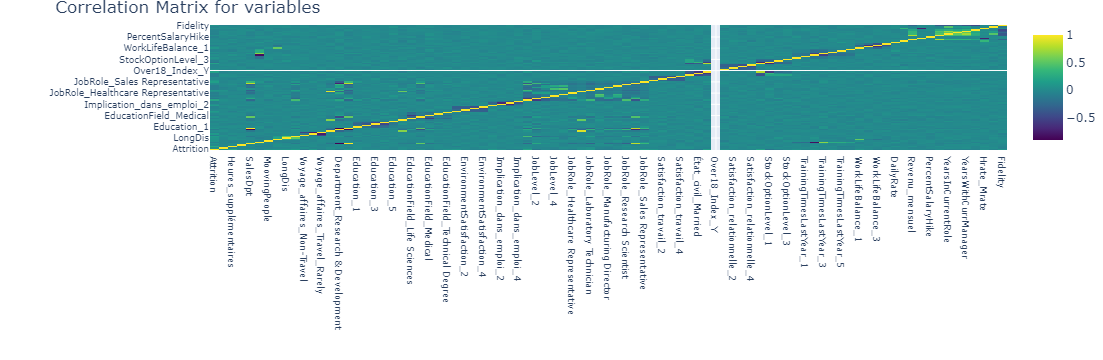

In [19]:
#correlation
correlation = data.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale='Viridis',
                   colorbar   = dict() ,
                  )
layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                        autosize = False,
                        #height  = 1400,
                        #width   = 1600,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                     ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9)),
                       )
                  )
fig = go.Figure(data = [trace],layout = layout)
py.iplot(fig)

## <a id='3.5'>3.5. Remove collinear features</a>

In [20]:
# Threshold for removing correlated variables
threshold = 0.8

# Absolute value correlation matrix
corr_matrix = data.corr().abs()
corr_matrix.head()

# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
upper.head()

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove :' % (len(to_drop)))

data = data.drop(columns = to_drop)

to_drop

There are 5 columns to remove :


['Department_Research & Development',
 'Department_Sales',
 'JobRole_Human Resources',
 'JobRole_Sales Executive',
 'TrainingTimesLastYear_2']

# <a id='4'>4. Define functions</a>

## <a id='4.1'>4.1. Define model performance plot</a> 

In [21]:
def model_performance_plot(model) : 
    #conf matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #plot roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_score) , 3)
    fpr, tpr, t = roc_curve(y_test, y_score)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : ",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                        subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance</b><br>'+str(model),
                        autosize = False, height = 900,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

## <a id='4.2'>4.2. Define feature importance plot</a> 

In [22]:
def features_imp(model, cf) : 

    coefficients  = pd.DataFrame(model.feature_importances_)
    column_data     = pd.DataFrame(list(data))
    coef_sumry    = (pd.merge(coefficients,column_data,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    coef_sumry = coef_sumry[coef_sumry["coefficients"] !=0]
    trace = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Viridis",
                                  line = dict(width = .6,color = "black")))
    layout = dict(title =  'Feature Importances xgb_cfl')
                    
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

## <a id='4.3'>4.3. Define cumulative gains curve</a> 

In [23]:
#cumulative gain curve
def cum_gains_curve(model):
    pos = pd.get_dummies(y_test).as_matrix()
    pos = pos[:,1] 
    npos = np.sum(pos)
    index = np.argsort(y_score) 
    index = index[::-1] 
    sort_pos = pos[index]
    #cumulative sum
    cpos = np.cumsum(sort_pos) 
    #recall
    recall = cpos/npos 
    #size obs test
    n = y_test.shape[0] 
    size = np.arange(start=1,stop=369,step=1) 
    #proportion
    size = size / n 
    #plots
    model = 'xgb_cfl'
    trace1 = go.Scatter(x = size,y = recall,
                        name = "Lift curve",
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace2 = go.Scatter(x = size,y = size,
                        name = "Baseline",
                        showlegend=False,
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))

    layout = dict(title = 'Cumulative gains curve'+' '+str(model),
                  yaxis = dict(title = 'Percentage positive targeted',zeroline = False),
                  xaxis = dict(title = 'Percentage contacted', zeroline = False)
                 )

    fig  = go.Figure(data = [trace1,trace2], layout = layout)
    py.iplot(fig)

## <a id='4.4'>4.4. Define cross validation metrics</a> 

In [24]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

# <a id='5'>5. Prepare dataset</a>

## <a id='5.1'>5.1. Define (X, y)</a> 

In [25]:
# Def X and Y
y = np.array(data.Attrition.tolist())
data = data.drop(columns='Attrition')
X = np.array(data.values)

## <a id='5.2'>5.2. Train test split</a> 

In [26]:
# Train_test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state)

# <a id='6'>6. XGBoost - RandomizedSearchCV to optimize hyperparameters</a>

In [27]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)


# A parameter grid for XGBoost
params = {
        'n_estimators' : [100, 200, 500, 750],
        'learning_rate' : [0.01, 0.02, 0.05, 0.1, 0.25],
        'min_child_weight': [1, 5, 7, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 10, 12]
        }

folds = 5
param_comb = 800

random_search = RandomizedSearchCV(xgb_cfl, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42)

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
#----------------------------# random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable

NameError: name 'xgb' is not defined

Remove "#----------------------------#" to lunch random_search

In [ ]:
#print('\n All results:')
#print(random_search.cv_results_)
#print('\n Best estimator:')
#print(random_search.best_estimator_)
#print('\n Best accuracy for %d-fold search with %d parameter combinations:' % (folds, param_comb))
#print(random_search.best_score_ )
#print('\n Best hyperparameters:')
#print(random_search.best_params_)
#results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)



**RESULT : **

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=200, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)

 Best accuracy for 5-fold search with 800 parameter combinations:
0.891156462585034

 Best hyperparameters:
{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 1.5, 'colsample_bytree': 0.8}

# <a id='7'>7. XGBoost - Modeling with best hyperparameters = 89.11</a>

## <a id='7.1'>7.1. XGBoost - Modeling and performance plot</a> 

In [ ]:
# xgb 
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                           colsample_bytree=0.8, gamma=1.5, learning_rate=0.05,
                           max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
                           n_estimators=200, n_jobs=-1, nthread=None,
                           objective='binary:logistic', random_state=0, reg_alpha=0,
                           reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                           subsample=0.6)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:,1]

model_performance_plot('xgb_clf')

## <a id='7.2'>7.2. XGBoost - Feature importance </a>

In [ ]:
features_imp(xgb_clf, 'features')

In [ ]:
#feature importance plot TOP 40
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def plot_feature_importance(model):
    tmp = pd.DataFrame({'Feature': list(data), 'Feature importance': model.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False).head(30)
    plt.figure(figsize = (10,12))
    plt.title('Top 30 - Features importance - XGBoost',fontsize=14)
    s = sns.barplot(y='Feature',x='Feature importance',data=tmp, orient='h')
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

In [ ]:
plot_feature_importance(xgb_clf)

## <a id='7.3'>7.3. XGBoost - Cumulative gain curve</a> 

In [ ]:
cum_gains_curve(xgb_clf)

## <a id='7.4'>7.4. XGBoost - Cross validation (5 folds)</a> 

In [ ]:
# Cross val score
cross_val_metrics(xgb_clf)

**Thank you all ! Merci à tous ! :)**